In [1]:
import os
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as compare_ssim
import math

/home/vimarsh/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
class SRDataset(Dataset):
    def __init__(self, hr_files, lr_files, transform=None):
        """
        hr_files: list of file paths for high-resolution (.npy) images.
        lr_files: list of file paths for low-resolution (.npy) images.
        Assumes matching filenames between HR and LR files.
        """
        self.hr_files = hr_files
        self.lr_files = lr_files
        assert len(self.hr_files) == len(self.lr_files), "Mismatch in number of HR and LR images"
        self.transform = transform

    def __len__(self):
        return len(self.hr_files)

    def __getitem__(self, idx):
        hr = np.load(self.hr_files[idx]).astype(np.float32)  # expected shape: (C, H, W)
        lr = np.load(self.lr_files[idx]).astype(np.float32)  # expected shape: (C, H_lr, W_lr)
        
        if self.transform:
            hr = self.transform(hr)
            lr = self.transform(lr)
        # Convert numpy arrays to torch tensors
        hr = torch.from_numpy(hr)
        lr = torch.from_numpy(lr)
        return lr, hr

In [3]:
class SRCNN(nn.Module):
    def __init__(self, scale_factor=2):
        """
        A simple SRCNN-style model.
        The LR image is first upsampled using bicubic interpolation, then refined.
        """
        super(SRCNN, self).__init__()
        self.scale = scale_factor
        #architecture is inspired by the original SRCNN paper:
        # Conv1: 9x9 kernel, 64 filters, ReLU; Conv2: 1x1 kernel, 32 filters, ReLU; Conv3: 5x5 kernel, 1 filter.
        self.conv1 = nn.Conv2d(1, 64, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1)
        self.conv3 = nn.Conv2d(32, 1, kernel_size=5, padding=2)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        #upscaling LR image to HR dimensions using bicubic interpolation
        x = F.interpolate(x, scale_factor=self.scale, mode='bicubic', align_corners=False)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [4]:
def calc_psnr(mse, max_val=1.0):
    return 10 * math.log10(max_val**2 / mse)

In [5]:
def evaluate(model, device, test_loader):
    model.eval()
    mse_total = 0.0
    ssim_total = 0.0
    count = 0
    with torch.no_grad():
        for lr, hr in test_loader:
            lr, hr = lr.to(device), hr.to(device)
            output = model(lr)
            mse = F.mse_loss(output, hr, reduction='mean').item()
            mse_total += mse

            # Compute SSIM for each image in the batch
            output_np = output.cpu().numpy()
            hr_np = hr.cpu().numpy()
            for i in range(output_np.shape[0]):
                # Rearrange from (C, H, W) to (H, W, C)
                # output_img = np.transpose(output_np[i], (1, 2, 0))
                # hr_img = np.transpose(hr_np[i], (1, 2, 0))
                # # data_range is computed from hr image values
                # # ssim_val = compare_ssim(hr_img, output_img, multichannel=False, data_range=hr_img.max() - hr_img.min(), win_size=7)
                # # ssim_total += ssim_val
                # count += 1

                # Rearrange from (C, H, W) to (H, W, C)

                output_img = np.transpose(output_np[i], (1, 2, 0))
                hr_img = np.transpose(hr_np[i], (1, 2, 0))
                # If single channel, squeezing the last dimension to get a 2D array
                if output_img.shape[2] == 1:
                    output_img = output_img.squeeze(axis=2)

                if hr_img.shape[2] == 1:
                    hr_img = hr_img.squeeze(axis=2)
                ssim_val = compare_ssim(hr_img, output_img, data_range=hr_img.max() - hr_img.min(), win_size=7)
                ssim_total += ssim_val
                count += 1


    avg_mse = mse_total / len(test_loader)
    avg_psnr = calc_psnr(avg_mse)
    avg_ssim = ssim_total / count
    print(f"Average MSE: {avg_mse:.6f}")
    print(f"Average PSNR: {avg_psnr:.2f} dB")
    print(f"Average SSIM: {avg_ssim:.4f}")
    return avg_mse, avg_psnr, avg_ssim


#visualizing the results
def visualize_results(model, device, test_loader):
    model.eval()
    with torch.no_grad():
        for lr, hr in test_loader:
            lr, hr = lr.to(device), hr.to(device)
            output = model(lr)
            break
    lr = lr.cpu().numpy()
    hr = hr.cpu().numpy()
    output = output.cpu().numpy()
    indices = np.random.choice(lr.shape[0], size=1, replace=False)  # randomly select 5 images
    for i in indices:
        fig, axs = plt.subplots(2, 3, figsize=(12, 8))
        axs[0, 0].imshow(np.transpose(lr[i], (1, 2, 0)))
        axs[0, 0].set_title("LR (Color)")
        axs[0, 1].imshow(np.transpose(output[i], (1, 2, 0)))
        axs[0, 1].set_title("SR (Color)")
        axs[0, 2].imshow(np.transpose(hr[i], (1, 2, 0)))
        axs[0, 2].set_title("HR (Color)")
        
        axs[1, 0].imshow(np.transpose(lr[i], (1, 2, 0)), cmap='gray')
        axs[1, 0].set_title("LR (B&W)")
        axs[1, 1].imshow(np.transpose(output[i], (1, 2, 0)), cmap='gray')
        axs[1, 1].set_title("SR (B&W)")
        axs[1, 2].imshow(np.transpose(hr[i], (1, 2, 0)), cmap='gray')
        axs[1, 2].set_title("HR (B&W)")
        
        for ax in axs.flat:
            ax.axis('off')
        plt.show()

In [6]:
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    running_loss = 0.0
    for batch_idx, (lr, hr) in enumerate(train_loader):
        lr, hr = lr.to(device), hr.to(device)
        optimizer.zero_grad()
        output = model(lr)
        loss = criterion(output, hr)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if batch_idx % 10 == 0:
            print(f"Epoch {epoch} Batch {batch_idx} Loss: {loss.item():.4f}")

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch} Average Loss: {avg_loss:.4f}")
    return avg_loss


Epoch 1 Batch 0 Loss: 0.0120
Epoch 1 Batch 10 Loss: 0.0082
Epoch 1 Batch 20 Loss: 0.0055
Epoch 1 Batch 30 Loss: 0.0028
Epoch 1 Average Loss: 0.0064
Epoch 2 Batch 0 Loss: 0.0016
Epoch 2 Batch 10 Loss: 0.0005
Epoch 2 Batch 20 Loss: 0.0005
Epoch 2 Batch 30 Loss: 0.0004
Epoch 2 Average Loss: 0.0006
Epoch 3 Batch 0 Loss: 0.0004
Epoch 3 Batch 10 Loss: 0.0003
Epoch 3 Batch 20 Loss: 0.0003
Epoch 3 Batch 30 Loss: 0.0003
Epoch 3 Average Loss: 0.0003
Epoch 4 Batch 0 Loss: 0.0003
Epoch 4 Batch 10 Loss: 0.0002
Epoch 4 Batch 20 Loss: 0.0002
Epoch 4 Batch 30 Loss: 0.0002
Epoch 4 Average Loss: 0.0002
Epoch 5 Batch 0 Loss: 0.0002
Epoch 5 Batch 10 Loss: 0.0002
Epoch 5 Batch 20 Loss: 0.0002
Epoch 5 Batch 30 Loss: 0.0002
Epoch 5 Average Loss: 0.0002
Epoch 6 Batch 0 Loss: 0.0002
Epoch 6 Batch 10 Loss: 0.0002
Epoch 6 Batch 20 Loss: 0.0002
Epoch 6 Batch 30 Loss: 0.0001
Epoch 6 Average Loss: 0.0002
Epoch 7 Batch 0 Loss: 0.0001
Epoch 7 Batch 10 Loss: 0.0001
Epoch 7 Batch 20 Loss: 0.0001
Epoch 7 Batch 30 Loss: 

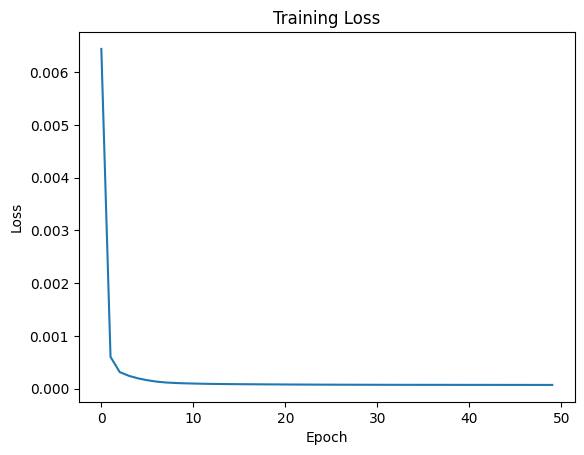

In [7]:
from sklearn.model_selection import train_test_split

# Task III.A: dataset

hr_dir = '/home/vimarsh/Desktop/3-2/GSoC/ML4Sci/SuperRes_Dataset/Dataset/HR'
lr_dir = '/home/vimarsh/Desktop/3-2/GSoC/ML4Sci/SuperRes_Dataset/Dataset/LR'

hr_files = sorted(glob.glob(os.path.join(hr_dir, '*.npy')))
lr_files = sorted(glob.glob(os.path.join(lr_dir, '*.npy')))
assert len(hr_files) == len(lr_files), "Mismatch in number of HR and LR images"

#(90% train, 10% val)
train_hr_files, test_hr_files, train_lr_files, test_lr_files = train_test_split(hr_files, lr_files, test_size=0.1, random_state=42)

train_dataset = SRDataset(train_hr_files, train_lr_files)
test_dataset = SRDataset(test_hr_files, test_lr_files)

#hyprparams
batch_size = 256
num_epochs = 50
learning_rate = 1e-4
scale_factor = 2  # adjust according to your dataset's scaling factor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

model = SRCNN(scale_factor=scale_factor).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

# Training loop
losses = []
for epoch in range(1, num_epochs + 1):
    losses.append(train(model, device, train_loader, optimizer, criterion, epoch))

#visualize loss
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


In [8]:

# Evaluation
print("Evaluating on train set:")
evaluate(model, device, train_loader)
print("Evaluating on val set:")
evaluate(model, device, test_loader)

Evaluating on train set:
Average MSE: 0.000068
Average PSNR: 41.67 dB
Average SSIM: 0.9741
Evaluating on val set:
Average MSE: 0.000068
Average PSNR: 41.65 dB
Average SSIM: 0.9740


(6.835697422502562e-05, 41.65217169275727, 0.9739973187895727)

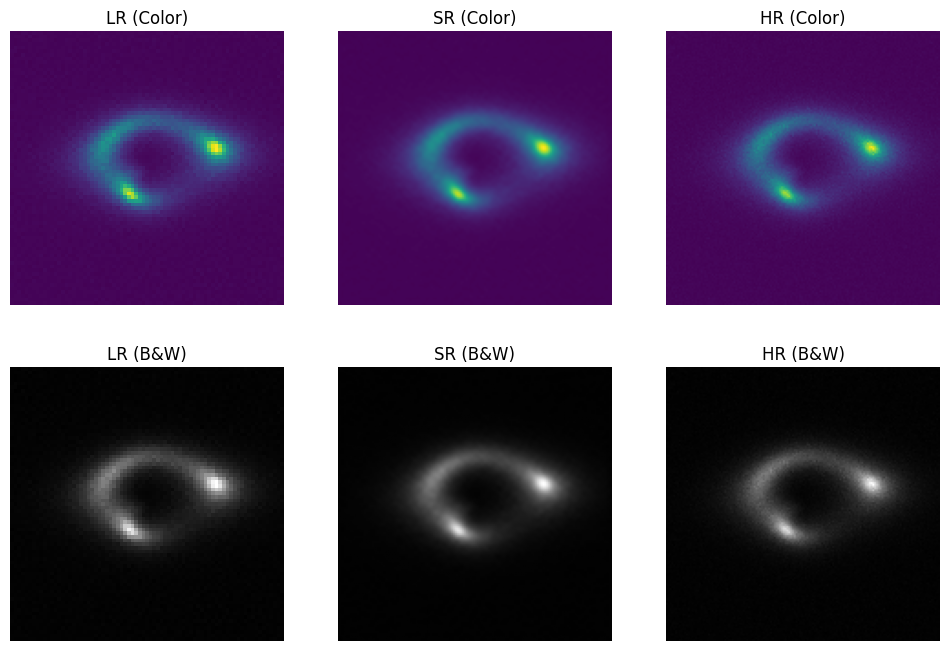

In [9]:
visualize_results(model, device, train_loader)

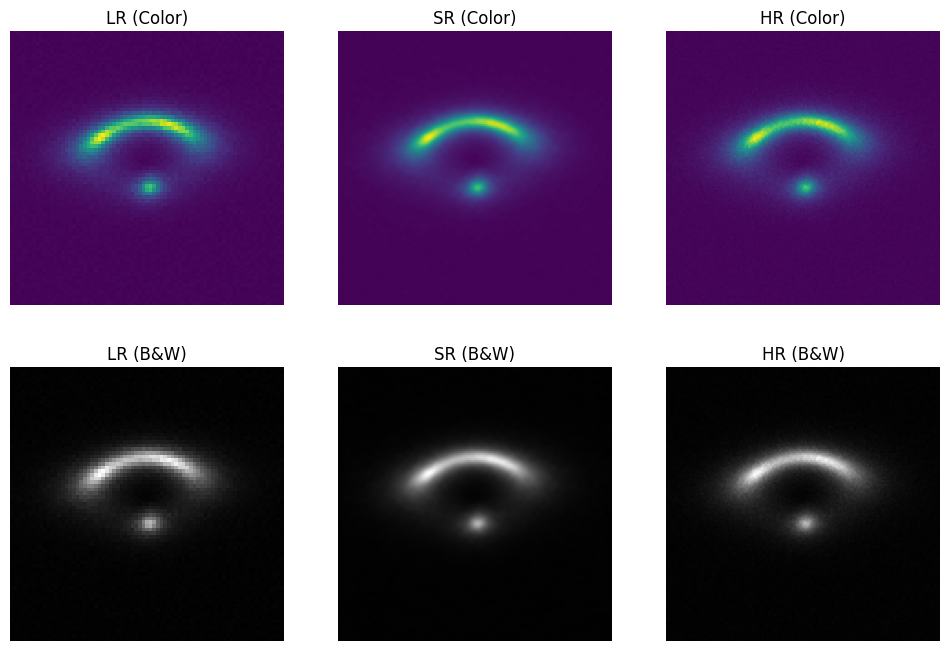

In [10]:
visualize_results(model, device, test_loader)

In [11]:
#save model as pretrained pth
torch.save(model.state_dict(), 'srcnn_pretrained_old.pth')

Loading pretrained weights from big dataset...


/tmp/ipykernel_170858/1314873007.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(pretrained_path, map_location=device)


Epoch 1 Batch 0 Loss: 0.0038
Epoch 1 Batch 10 Loss: 0.0075
Epoch 1 Batch 20 Loss: 0.0038
Epoch 1 Batch 30 Loss: 0.0012
Epoch 1 Batch 40 Loss: 0.0012
Epoch 1 Batch 50 Loss: 0.0026
Epoch 1 Batch 60 Loss: 0.0028
Epoch 1 Batch 70 Loss: 0.0007
Epoch 1 Batch 80 Loss: 0.0012
Epoch 1 Batch 90 Loss: 0.0008
Epoch 1 Batch 100 Loss: 0.0009
Epoch 1 Batch 110 Loss: 0.0006
Epoch 1 Batch 120 Loss: 0.0012
Epoch 1 Batch 130 Loss: 0.0008
Epoch 1 Average Loss: 0.0024
Epoch 2 Batch 0 Loss: 0.0064
Epoch 2 Batch 10 Loss: 0.0016
Epoch 2 Batch 20 Loss: 0.0004
Epoch 2 Batch 30 Loss: 0.0005
Epoch 2 Batch 40 Loss: 0.0007
Epoch 2 Batch 50 Loss: 0.0010
Epoch 2 Batch 60 Loss: 0.0006
Epoch 2 Batch 70 Loss: 0.0007
Epoch 2 Batch 80 Loss: 0.0006
Epoch 2 Batch 90 Loss: 0.0004
Epoch 2 Batch 100 Loss: 0.0003
Epoch 2 Batch 110 Loss: 0.0005
Epoch 2 Batch 120 Loss: 0.0022
Epoch 2 Batch 130 Loss: 0.0006
Epoch 2 Average Loss: 0.0016
Epoch 3 Batch 0 Loss: 0.0005
Epoch 3 Batch 10 Loss: 0.0009
Epoch 3 Batch 20 Loss: 0.0019
Epoch 3

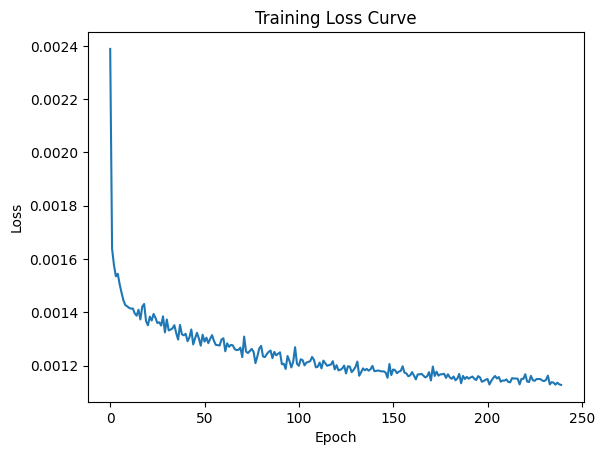

In [17]:

# Task III.B: small dataset 

batch_size = 2            # Smaller batch size given the limited data
num_epochs = 240          
learning_rate = 5e-5     
scale_factor = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


hr_dir = '/home/vimarsh/Desktop/3-2/GSoC/ML4Sci/Dataset 3B/Dataset/HR'
lr_dir = '/home/vimarsh/Desktop/3-2/GSoC/ML4Sci/Dataset 3B/Dataset/LR'

hr_files = sorted(glob.glob(os.path.join(hr_dir, '*.npy')))
lr_files = sorted(glob.glob(os.path.join(lr_dir, '*.npy')))
assert len(hr_files) == len(lr_files), "Mismatch in number of HR and LR images"

# (90% train, 10% val)
train_hr_files, test_hr_files, train_lr_files, test_lr_files = train_test_split(hr_files, lr_files, test_size=0.1, random_state=42)

train_dataset = SRDataset(train_hr_files, train_lr_files)
test_dataset = SRDataset(test_hr_files, test_lr_files)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

model = SRCNN(scale_factor=scale_factor).to(device)
pretrained_path = 'srcnn_pretrained_old.pth'
if os.path.exists(pretrained_path):
    print("Loading pretrained weights from big dataset...")
    state_dict = torch.load(pretrained_path, map_location=device)
    model.load_state_dict(state_dict)
else:
    print("Pretrained weights not found. Training from scratch on real data.")

#freeze early layers (conv1 and conv2) to retain generic features,
# fine-tuning only the last layer (conv3) for domain adaptation.

## unfreezing all, too see if full finetune is better??
# for param in model.conv1.parameters():
#     param.requires_grad = False
# for param in model.conv2.parameters():
#     param.requires_grad = False

#only parameters that require gradients will be updated.
# optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
criterion = nn.MSELoss()

losses = []
for epoch in range(1, num_epochs + 1):
    losses.append(train(model, device, train_loader, optimizer, criterion, epoch))
# for epoch in range(1, num_epochs + 1):
#     train(model, device, train_loader, optimizer, criterion, epoch)

#plot the loss curve
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()



In [13]:

print("Evaluating on train set:")
evaluate(model, device, train_loader)

print("Evaluating on val set:")
evaluate(model, device, test_loader)

Evaluating on train set:
Average MSE: 0.001355
Average PSNR: 28.68 dB
Average SSIM: 0.8092
Evaluating on val set:
Average MSE: 0.000862
Average PSNR: 30.65 dB
Average SSIM: 0.8495


(0.0008616066256460424, 30.646909700275636, 0.8495318945634931)

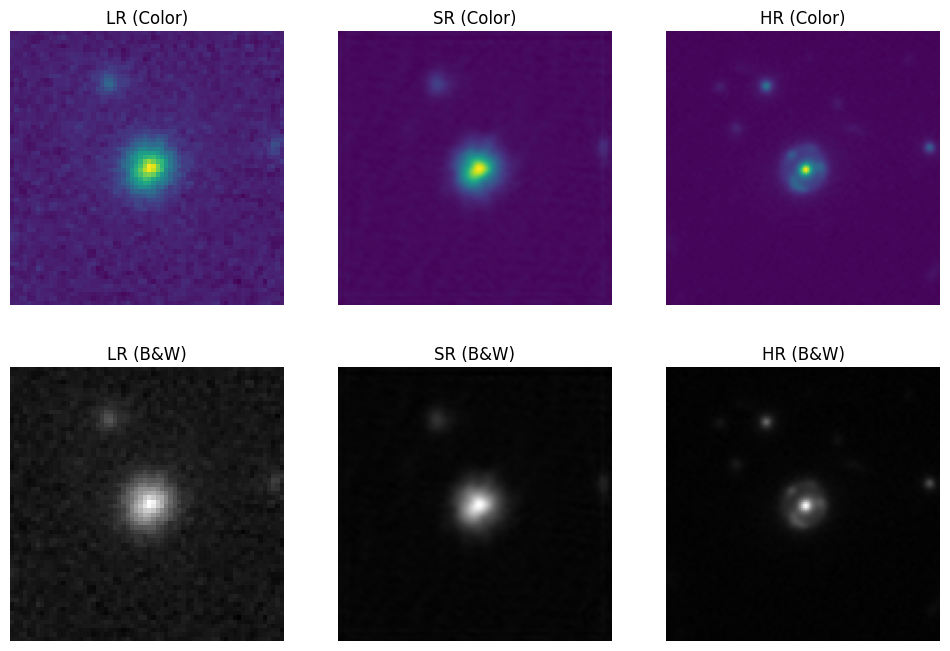

In [14]:
#visualioze
visualize_results(model, device, train_loader)

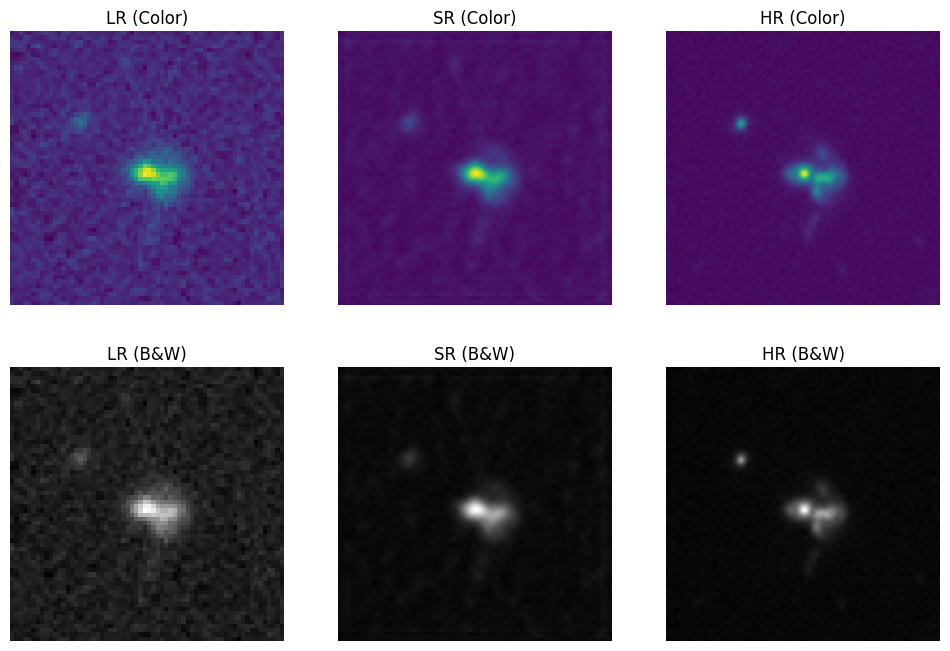

In [15]:
visualize_results(model, device, test_loader)

In [16]:
#save model
torch.save(model.state_dict(), 'srcnn_small_dataset.pth')